In [1]:
from sqlalchemy import create_engine, Table, inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.stats as st
from scipy.stats import norm

In [2]:
# Vi skapar en engine med en funktion
def new_engine(dialect, server, database, user=None, password=None, integrated_security=True):
    if integrated_security:
        # For Windows authentication
        eng = f"{dialect}://{server}/{database}?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server"
    else:
        # For SQL Server authentication
        eng = f"{dialect}://{user}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server"
    print(eng)
    return create_engine(eng)

In [3]:
engine = new_engine('mssql', 'DESKTOP-8JONHS0', 'AdventureWorks2022', integrated_security=True)

mssql://DESKTOP-8JONHS0/AdventureWorks2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server


In [4]:
con = engine.connect()

BESKRIVNING AV DATABASEN OCH FÔRETAGET <br>Översikt över databasen och relevant information om företaget

In [5]:
# Ôversikt över tabeller och views i relevanta schemas
tables_and_views = '''
SELECT A.Table_Schema AS Schemas
	, COUNT(*) AS TablesInSchemas
	, ViewCount.ViewsInSchemas
FROM information_schema.tables AS A
LEFT JOIN (
	SELECT Table_Schema AS Schemas
		, COUNT(*) AS ViewsInSchemas
	FROM information_schema.tables
	WHERE table_Schema NOT IN ('information_schema', 'sys', 'dbo')
		AND table_type <> 'Base Table' 
	GROUP BY Table_Schema
	) 
	AS ViewCount 
	ON A.Table_Schema = ViewCount.Schemas
WHERE A.Table_Schema NOT IN ('information_schema', 'sys', 'dbo')
	AND table_type = 'Base Table' 
GROUP BY A.Table_Schema, ViewCount.ViewsInSchemas
ORDER BY TablesInSchemas;
'''
tables_and_views = pd.read_sql(sql= tables_and_views, con=con) 
display(tables_and_views)

tables = np.sum(tables_and_views['TablesInSchemas'])
views = np.sum(tables_and_views['ViewsInSchemas'])
print(f'Nbr of tables: {tables}. Nbr of views: {views}')


,Schemas,TablesInSchemas,ViewsInSchemas
0,Purchasing,5,2
1,HumanResources,6,6
2,Person,14,2
3,Sales,19,10
4,Production,25,3


Nbr of tables: 69. Nbr of views: 23


In [6]:
# ÖVersikt över  anställda i varje avdelning
organisation = '''
SELECT A.DepartmentID
    , B.Name AS Department
    , COUNT(*) AS EmployeesInDepartment
    , B.GroupName
    , SUM(COUNT(*)) OVER () AS TotalEmployees
    , FORMAT((COUNT(*) * 100.0 / SUM(COUNT(*)) OVER ()), '0') + '%' AS '%OfWorkforce'
FROM HumanResources.EmployeeDepartmentHistory AS A
INNER JOIN HumanResources.Department AS B 
	ON A.DepartmentID = B.DepartmentID
WHERE A.EndDate IS NULL
GROUP BY A.DepartmentID, B.Name, B.GroupName
ORDER BY EmployeesInDepartment DESC;
'''
organisation = pd.read_sql(sql = organisation, con=con)
display(organisation.head())

,DepartmentID,Department,EmployeesInDepartment,GroupName,TotalEmployees,%OfWorkforce
0,7,Production,179,Manufacturing,290,62%
1,3,Sales,18,Sales and Marketing,290,6%
2,5,Purchasing,12,Inventory Management,290,4%
3,10,Finance,10,Executive General and Administration,290,3%
4,11,Information Services,10,Executive General and Administration,290,3%


In [8]:
# Översikt över nya anställda per år 
anställda_per_år = '''
SELECT YEAR(HireDate) AS HireYear
	, COUNT(*) AS NewHires
FROM HumanResources.Employee
GROUP BY YEAR(HireDate)
'''
anställda_per_år = pd.read_sql(sql = anställda_per_år, con=con)
display(anställda_per_år)

,HireYear,NewHires
0,2006,1
1,2007,6
2,2008,74
3,2009,148
4,2010,38
5,2011,16
6,2012,4
7,2013,3


In [9]:
# Nya anställda per avdelning och år
anställda_per_avdelning = '''
WITH department As
( 
SELECT Dep.DepartmentID
	, Dep.[Name]
	, Hist.BusinessEntityID
FROM HumanResources.Department AS Dep
	LEFT JOIN HumanResources.EmployeeDepartmentHistory As Hist
	ON Dep.DepartmentID = Hist.DepartmentID
)
SELECT YEAR(Emp.HireDate) AS HireYear
	, COUNT(*) AS NewHires
	, dept.[Name]
FROM HumanResources.Employee AS Emp
LEFT JOIN department AS Dept
	ON Emp.BusinessEntityID = Dept.BusinessEntityID
GROUP BY YEAR(Emp.HireDate), dept.[Name]
ORDER BY NewHires DESC;
'''
anställda_per_avdelning = pd.read_sql(sql = anställda_per_avdelning, con=con)
display(anställda_per_avdelning.head(5))

,HireYear,NewHires,Name
0,2009,104,Production
1,2008,52,Production
2,2010,22,Production
3,2011,11,Sales
4,2009,9,Finance


In [12]:
# Antall produkter som de sålde 2014
products = '''
SELECT COUNT(Pro.ProductID) AS NumberOfProducts
	, Cat.ProductCategory
FROM Production.Product AS Pro
LEFT JOIN Sales.vProductDetails AS Cat
	ON Pro.ProductID = Cat.ProductID
WHERE DiscontinuedDate IS NULL
GROUP BY Cat.ProductCategory
ORDER BY NumberOfProducts;
'''
product = pd.read_sql(sql = products, con=con)
display(product)

count = np.sum(product['NumberOfProducts'])
print(f'Nbr of products {count}')

,NumberOfProducts,ProductCategory
0,24,Accessories
1,34,Clothing
2,97,Bikes
3,111,Components
4,238,None


Nbr of products 504


In [13]:
# Försäljning (Quantity) per produktgrupp
sales_productgroup = ''' 
WITH quantitypergroup AS
(
SELECT YEAR(Ord.OrderDate) AS OrderYear
	, Pro.ProductCategory AS ProductCategory
	, SUM(Sales.OrderQty) AS Quantity
FROM Sales.SalesOrderHeader AS Ord
LEFT JOIN Sales.SalesOrderDetail AS Sales
	ON Ord.SalesOrderID = Sales.SalesOrderID
LEFT JOIN Sales.vProductDetails AS Pro
	ON Sales.ProductID = Pro.ProductID
GROUP BY YEAR(Ord.OrderDate), Pro.ProductCategory
)
SELECT * FROM quantitypergroup
PIVOT (SUM(Quantity) FOR ProductCategory IN ([Accessories], [Bikes], [Clothing], [Components])) AS PivotTable
;
'''
sales_productgroup = pd.read_sql(sql = sales_productgroup, con=con)
display(sales_productgroup)

,OrderYear,Accessories,Bikes,Clothing,Components
0,2011,1032,7963,2246,1647
1,2012,5750,28494,19228,15107
2,2013,32153,37748,37180,24707
3,2014,22997,16063,15016,7583


Text(0.5, 1.0, 'Quantity Per Product Group')

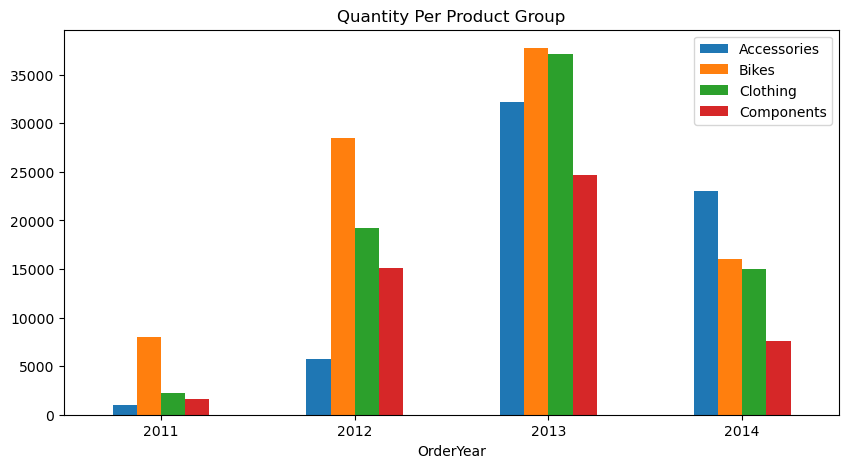

In [14]:
# Bar plot med quantity per produktgrupp
fig, ax = plt.subplots(figsize=(10, 5))
sales_productgroup.plot.bar(x='OrderYear', rot=0, ax=ax)
ax.set_title('Quantity Per Product Group')

In [15]:
# ôversikt över försäljning per marknad
group_results_year = ''' 
WITH profit AS
(
SELECT Ord.SalesOrderID
	, Ord.OrderDate 
	, Ord.TerritoryID
	, Ord.SalesPersonID
	, Sales.ProductID
	, Sales.OrderQty 
	, Hist.StandardCost 
	, Hist.StandardCost * Sales.OrderQty AS SalesProductCost
	, Sales.LineTotal 
	, Sales.LineTotal - Hist.StandardCost * Sales.OrderQty AS SalesProfit
FROM Sales.SalesOrderHeader AS Ord
LEFT JOIN Sales.SalesOrderDetail AS Sales
	ON Ord.SalesOrderID = Sales.SalesOrderID
LEFT JOIN Production.ProductCostHistory AS Hist
	ON Sales.ProductID = Hist.ProductID 
	AND Hist.StartDate  = (SELECT MAX(StartDate) FROM Production.ProductCostHistory
							WHERE ProductID = Hist.ProductID 
							AND StartDate <= Ord.OrderDate)
), group_results AS
(
SELECT  YEAR(OrderDate) AS OrderYear
	, Ter.[Group]
	, CONVERT(DECIMAL(10,2),SUM(LineTotal)) AS Revenue
	, CONVERT(DECIMAL(10,2),SUM(SalesProfit)) AS SalesProfit
FROM profit AS pr
LEFT JOIN Sales.SalesTerritory as Ter
	ON pr.TerritoryID = Ter.TerritoryID
GROUP BY YEAR(OrderDate) , Ter.[Group]
)
SELECT OrderYear
	, SUM(CASE WHEN [Group] = 'Europe' THEN Revenue ELSE 0 END) AS 'EuropeRevenue'
    , SUM(CASE WHEN [Group] = 'North America' THEN Revenue ELSE 0 END) AS 'NorthAmericaRevenue'
    , SUM(CASE WHEN [Group] = 'Pacific' THEN Revenue ELSE 0 END) AS 'PacificRevenue'
    , SUM(CASE WHEN [Group] = 'Europe' THEN SalesProfit ELSE 0 END) AS 'EuropeProfit'
    , SUM(CASE WHEN [Group] = 'North America' THEN SalesProfit ELSE 0 END) AS 'NorthAmericaProfit'
    , SUM(CASE WHEN [Group] = 'Pacific' THEN SalesProfit ELSE 0 END) AS 'PacificProfit'
FROM group_results
GROUP BY OrderYear
ORDER BY OrderYear
;
'''
group_results_year = pd.read_sql(sql = group_results_year, con=con)
display(group_results_year)


,OrderYear,EuropeRevenue,NorthAmericaRevenue,PacificRevenue,EuropeProfit,NorthAmericaProfit,PacificProfit
0,2011,823566.92,10285948.99,1532156.31,331234.27,953076.63,619230.25
1,2012,3689079.41,27710438.73,2124783.18,757836.34,1396826.86,870838.11
2,2013,10005149.75,29386664.97,4230664.32,1309261.32,1651651.54,1225331.61
3,2014,5319888.19,11970308.47,2767732.15,1130027.30,1450732.14,861734.22


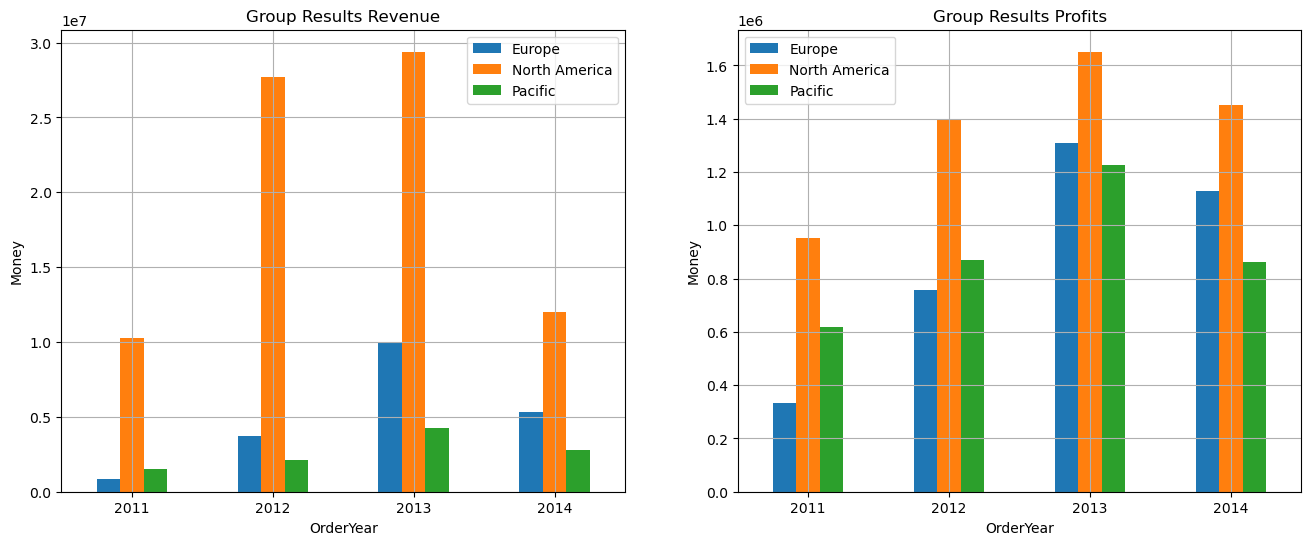

In [16]:
# Bar plots med gruppresultaterna
df_revenue = group_results_year[['OrderYear', 'EuropeRevenue', 'NorthAmericaRevenue', 'PacificRevenue']]
df_profit = group_results_year[['OrderYear', 'EuropeProfit', 'NorthAmericaProfit', 'PacificProfit']]

labels = ['Europe', 'North America', 'Pacific']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1 = df_revenue.plot.bar(x = 'OrderYear', rot=0, ax=ax1, legend=True)
ax2 = df_profit.plot.bar(x = 'OrderYear',  rot=0, ax=ax2, legend=True)

ax1.set_xlabel('OrderYear')
ax1.set_ylabel('Money')
ax1.set_title('Group Results Revenue')
ax1.legend(labels=labels)
ax1.grid(True)

ax2.set_xlabel('OrderYear')
ax2.set_ylabel('Money')
ax2.set_title('Group Results Profits')
ax2.legend(labels=labels, loc='upper left')
ax2.grid(True)

In [17]:
# Tabell med information om ordrar via salespersons och via online
orders_per_channel = '''
WITH SourceTable AS
(
SELECT 
	YEAR(OrderDate) AS OrderYear
	, IIF(OnlineOrderFlag = 0, 'SalesPerson', 'OnlineOrder') AS 'Channel'
	, COUNT(*) AS OrderNum
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate), OnlineOrderFlag
)
SELECT *
FROM SourceTable 
PIVOT (MAX(OrderNum) FOR Channel IN ([SalesPerson], [OnlineOrder])) AS PivotTable;
'''
orders_per_channel = pd.read_sql(sql = orders_per_channel, con=con)
display(orders_per_channel)

,OrderYear,SalesPerson,OnlineOrder
0,2011,406,1201
1,2012,1172,2743
2,2013,1598,12584
3,2014,630,11131


STATISTISK ANALYS <br>Nedan är kod som den statistiska analys baseras på

In [18]:
# ôversikt över de två kampanjerna
campaigns = '''
SELECT 
	CASE 
		WHEN SpecialOfferID = 8 THEN 'A'
		WHEN SpecialOfferID = 11 THEN 'B'
		ELSE 'Unknown'
	END AS Campaign
	, SpecialOfferID	
	, Description
	, DiscountPct
	, Category
	, StartDate
	, EndDate
FROM Sales.SpecialOffer
WHERE SpecialOfferID IN (8,11);

'''
campaigns = pd.read_sql(sql = campaigns, con=con)
display(campaigns)

,Campaign,SpecialOfferID,Description,DiscountPct,Category,StartDate,EndDate
0,A,8,Sport Helmet Discount-2002,0.10,Reseller,2012-05-30,2012-06-29
1,B,11,Sport Helmet Discount-2003,0.15,Reseller,2013-05-30,2013-06-29


In [19]:
# Helmet statistic med SpceialOffer 8 och 11 
helmet_sales_discount = '''
WITH profit AS
(
SELECT Ord.SalesOrderID 
	, Ord.OrderDate
	, Sales.ProductID
	, Sales.OrderQty
	, Sales.UnitPrice * (1-UnitPriceDiscount) AS UnitPriceDiscount
	, Hist.StandardCost
	, Hist.StandardCost * Sales.OrderQty AS SalesCost
	, LineTotal
	, LineTotal - (Hist.StandardCost * Sales.OrderQty) AS SalesProfit
FROM Sales.SalesOrderHeader AS Ord
LEFT JOIN Sales.SalesOrderDetail AS Sales
	ON Ord.SalesOrderID = Sales.SalesOrderID
LEFT JOIN Production.ProductCostHistory AS Hist
	ON Sales.ProductID = Hist.ProductID 
	AND Hist.StartDate  = (SELECT MAX(StartDate) FROM Production.ProductCostHistory
							WHERE ProductID = Hist.ProductID 
							AND StartDate <= Ord.OrderDate)
WHERE Sales.ProductID IN (707, 708, 711) AND Ord.SalesPersonID IS NOT NULL 
	AND Sales.SpecialOfferID IN (8, 11)
), agg_results AS
(
SELECT 
	 ROW_NUMBER() OVER (ORDER BY FORMAT(Pro.OrderDate, 'yyyy-MM-dd')) AS index_column 
	, FORMAT(Pro.OrderDate, 'yyyy-MM-dd') AS OrderDate
	, COUNT(SalesOrderID) AS Orders
	, SUM(Pro.OrderQty) AS Quantity
	, Pro.UnitPriceDiscount
	, Prod.ListPrice
	, Pro.StandardCost
	, CONVERT(DECIMAL(10,2), SUM(Pro.LineTotal)) AS Revenue
	, CONVERT(DECIMAL(10,2), SUM(Pro.SalesProfit)) AS SalesProfit
FROM profit AS pro
LEFT JOIN Production.Product AS Prod
	ON Pro.ProductID = Prod.ProductID
GROUP BY FORMAT(Pro.OrderDate, 'yyyy-MM-dd'), Pro.UnitPriceDiscount, Pro.StandardCost, Prod.ListPrice
)
SELECT CASE 
		WHEN index_column = 1 THEN 'A'
		WHEN index_column = 2 THEN 'B'
		ELSE NULL
	 END AS Campaign
	, CASE 
		WHEN index_column = 1 THEN 0.10
		WHEN index_column = 2 THEN 0.15
		ELSE NULL
	 END AS DiscountPct
	, Orders
	, UnitPriceDiscount
	, ListPrice
	, StandardCost
	, Quantity
	, Revenue
	, SalesProfit
FROM agg_results 
ORDER BY OrderDate;
'''

helmet_sales_discount = pd.read_sql(sql = helmet_sales_discount, con=con)
display(helmet_sales_discount)

,Campaign,DiscountPct,Orders,UnitPriceDiscount,ListPrice,StandardCost,Quantity,Revenue,SalesProfit
0,A,0.10,98,15.1399,34.99,13.8782,492,7448.83,620.75
1,B,0.15,84,13.3837,34.99,13.0863,680,9100.90,202.22


In [20]:
# Helmet sales utan discount från salespersons
helmet_sales = '''
WITH profit AS
(
SELECT Ord.SalesOrderID 
	, Ord.OrderDate
	, Sales.ProductID
	, Sales.OrderQty
	, Hist.StandardCost
	, Hist.StandardCost * Sales.OrderQty AS SalesCost
	, Sales.LineTotal
	, Sales.LineTotal - (Hist.StandardCost * Sales.OrderQty) AS SalesProfit
FROM Sales.SalesOrderHeader AS Ord
LEFT JOIN Sales.SalesOrderDetail AS Sales
	ON Ord.SalesOrderID = Sales.SalesOrderID
LEFT JOIN Production.ProductCostHistory AS Hist
	ON Sales.ProductID = Hist.ProductID 
	AND Hist.StartDate  = (SELECT MAX(StartDate) FROM Production.ProductCostHistory
							WHERE ProductID = Hist.ProductID 
							AND StartDate <= Ord.OrderDate)
WHERE Sales.ProductID IN (707, 708, 711) AND Ord.SalesPersonID IS NOT NULL 
	AND Sales.SpecialOfferID = 1
)
SELECT FORMAT(OrderDate, 'yyyy-MM') AS OrderDate
	, COUNT(SalesOrderID) AS SumOfOrders
	, SUM(OrderQty) AS Quantity
	, CONVERT(DECIMAL(10,2), SUM(LineTotal)) AS Revenue
	, CONVERT(DECIMAL(10,2), SUM(SalesProfit)) AS SalesProfit
FROM profit
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY FORMAT(OrderDate, 'yyyy-MM');
'''

helmet_sales = pd.read_sql(sql = helmet_sales, con=con)
display(helmet_sales.head())


,OrderDate,SumOfOrders,Quantity,Revenue,SalesProfit
0,2011-05,37,84,1695.67,685.33
1,2011-07,67,178,3593.20,1452.25
2,2011-08,100,257,5187.93,2096.79
3,2011-10,141,473,9548.21,3859.07
4,2011-12,14,29,585.41,236.60


In [21]:
# shapirotest för att se om datan i helmet_sales per månad är normalfördelad
orders = helmet_sales.SumOfOrders
print(f'Orders: {st.shapiro(orders)}')
quantity = helmet_sales.Quantity
print(f'Quantity: {st.shapiro(quantity)}')
revenue = helmet_sales.Revenue
print(f'Revenue: {st.shapiro(revenue)}')
profit = helmet_sales.SalesProfit
print(f'Profit: {st.shapiro(profit)}')

Orders: ShapiroResult(statistic=0.9556733965873718, pvalue=0.20841047167778015)
Quantity: ShapiroResult(statistic=0.9560607075691223, pvalue=0.21367627382278442)
Revenue: ShapiroResult(statistic=0.9556838870048523, pvalue=0.2085515260696411)
Profit: ShapiroResult(statistic=0.9496000409126282, pvalue=0.1404019594192505)


Text(0, 0.5, 'Sum')

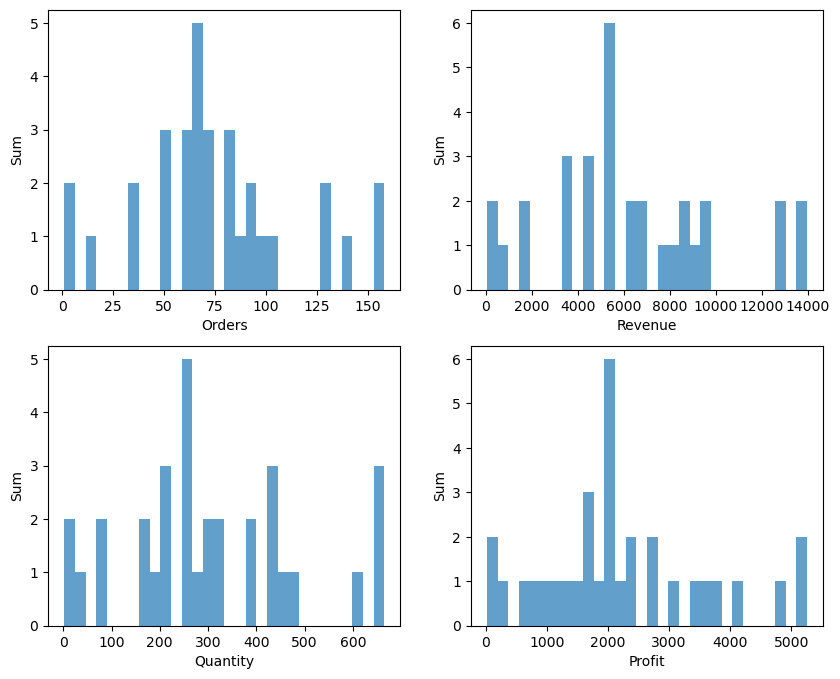

In [22]:
# histogram för normalfördelningarna med helmet_sales per månad datan
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

ax[0, 0].hist(orders, bins=30, alpha=0.7) 
ax[0, 0].set_xlabel('Orders')
ax[0, 0].set_ylabel('Sum')

ax[1, 0].hist(quantity, bins=30, alpha=0.7)
ax[1, 0].set_xlabel('Quantity')
ax[1, 0].set_ylabel('Sum')

ax[0, 1].hist(revenue, bins=30, alpha=0.7)
ax[0, 1].set_xlabel('Revenue')
ax[0, 1].set_ylabel('Sum')

ax[1, 1].hist(profit, bins=30, alpha=0.7)
ax[1, 1].set_xlabel('Profit')
ax[1, 1].set_ylabel('Sum')


In [23]:
ci_orders = stats.norm.interval(0.95, loc=np.mean(orders), scale=stats.sem(orders))
lower_bound_o, upper_bound_o = ci_orders
print(f'KI för orders per månad: {lower_bound_o:.2f} < mu < {upper_bound_o:.2f}')

ci_quantity = stats.norm.interval(0.95, loc=np.mean(quantity), scale=stats.sem(quantity))
lower_bound_q, upper_bound_q = ci_quantity
print(f'KI för quantity per månad: {lower_bound_q:.2f} < mu < {upper_bound_q:.2f}')

ci_revenue = stats.norm.interval(0.95, loc=np.mean(revenue), scale=stats.sem(revenue))
lower_bound_r, upper_bound_r = ci_revenue
print(f'KI för revenue per månad: {lower_bound_r:.2f} < mu < {upper_bound_r:.2f}')

ci_profit = stats.norm.interval(0.95, loc=np.mean(profit), scale=stats.sem(profit))
lower_bound_p, upper_bound_p = ci_profit
print(f'KI för profit per månad: {lower_bound_p:.2f} < mu < {upper_bound_p:.2f}')

KI för orders per månad: 61.51 < mu < 88.12
KI för quantity per månad: 241.92 < mu < 367.02
KI för revenue per månad: 4951.97 < mu < 7556.05
KI för profit per månad: 1763.20 < mu < 2713.69


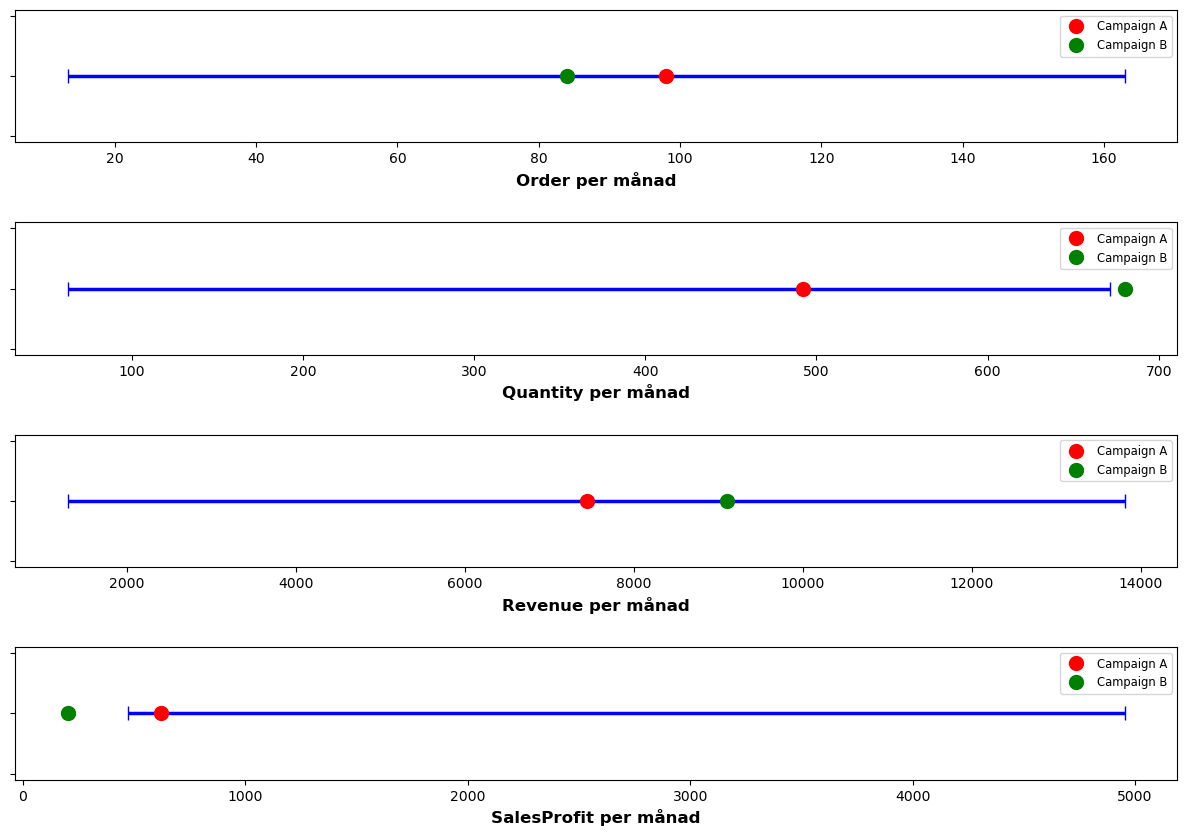

In [24]:
fig, ax = plt.subplots(4,1, figsize=(15,10))
fig.subplots_adjust(hspace=0.6)

ax[0].errorbar(x=(lower_bound_o + upper_bound_o) / 2, y=1, xerr=[[lower_bound_o], [upper_bound_o]], fmt='_', color='blue', capsize=5, linewidth=2.5)
ax[0].set_xlabel('Order per månad', fontweight='bold', fontsize=12)
ax[0].set_yticklabels([])
ax[0].plot(98, 1, 'ro', markersize=10,label='Campaign A')
ax[0].plot(84, 1, 'go', markersize=10, label='Campaign B')
ax[0].legend(fontsize='small')

ax[1].errorbar(x=(lower_bound_q + upper_bound_q) / 2, y=1, xerr=[[lower_bound_q], [upper_bound_q]], fmt='_', color='blue', capsize=5, linewidth=2.5)
ax[1].set_xlabel('Quantity per månad', fontweight='bold', fontsize=12 )
ax[1].set_yticklabels([])
ax[1].plot(492, 1, 'ro', markersize=10, label='Campaign A')
ax[1].plot(680, 1, 'go',markersize=10, label='Campaign B')
ax[1].legend(fontsize='small')

ax[2].errorbar(x=(lower_bound_r + upper_bound_r) / 2, y=1, xerr=[[lower_bound_r], [upper_bound_r]], fmt='_', color='blue', capsize=5, linewidth=2.5)
ax[2].set_xlabel('Revenue per månad', fontweight='bold', fontsize=12)
ax[2].set_yticklabels([])
ax[2].plot(7448, 1, 'ro', markersize=10, label='Campaign A')
ax[2].plot(9100, 1, 'go', markersize=10, label='Campaign B')
ax[2].legend(fontsize='small')
 
ax[3].errorbar(x=(lower_bound_p + upper_bound_p) / 2, y=1, xerr=[[lower_bound_p], [upper_bound_p]], fmt='_', color='blue', capsize=5, linewidth=2.5)
ax[3].set_xlabel('SalesProfit per månad', fontweight='bold', fontsize=12)
ax[3].set_yticklabels([])
ax[3].plot(620, 1, 'ro', markersize=10, label='Campaign A')
ax[3].plot(202, 1, 'go', markersize=10, label='Campaign B')
ax[3].legend(fontsize='small')

Nedan förljar uträkning av konfidensintervall för kampanjerna med SpecialOffer 8 och SpecialOffer 11, och för den vanliga försäljningen - uträknad per SalesOrder

In [25]:
# tabell över ordrar med specialoffer 8
specialoffer_8 = '''
WITH profit AS
(
SELECT Ord.SalesOrderID 
	, Ord.OrderDate
	, Sales.ProductID
	, Sales.OrderQty
	, Hist.StandardCost
	, Hist.StandardCost * Sales.OrderQty AS SalesCost
	, LineTotal
	, LineTotal - (Hist.StandardCost * Sales.OrderQty) AS SalesProfit
FROM Sales.SalesOrderHeader AS Ord
LEFT JOIN Sales.SalesOrderDetail AS Sales
	ON Ord.SalesOrderID = Sales.SalesOrderID
LEFT JOIN Production.ProductCostHistory AS Hist
	ON Sales.ProductID = Hist.ProductID 
	AND Hist.StartDate  = (SELECT MAX(StartDate) FROM Production.ProductCostHistory
							WHERE ProductID = Hist.ProductID 
							AND StartDate <= Ord.OrderDate)
WHERE Sales.ProductID IN (707, 708, 711) AND Ord.SalesPersonID IS NOT NULL 
	AND Sales.SpecialOfferID = 8
)
SELECT SalesOrderID 
	, SUM(OrderQty) AS Quantity
	, SUM(LineTotal) AS SalesOrderRevenue
	, SUM(SalesProfit) AS SalesOrderProfit
FROM profit
GROUP BY SalesOrderID;
'''
specialoffer_8 = pd.read_sql(sql = specialoffer_8, con=con)
display(specialoffer_8.head())

,SalesOrderID,Quantity,SalesOrderRevenue,SalesOrderProfit
0,46604,11,166.53879,13.87859
1,46605,5,75.69945,6.30845
2,46608,18,272.51802,22.71042
3,46611,12,181.67868,15.14028
4,46614,25,378.49725,31.54225


In [26]:
# shapirotest för specialoffer 8 per salesorder
sp8_quantity = specialoffer_8.Quantity
print(f'Orders: {st.shapiro(sp8_quantity)}')
sp8_revenue = specialoffer_8.SalesOrderRevenue
print(f'Revenue: {st.shapiro(sp8_revenue)}')
sp8_profit = specialoffer_8.SalesOrderProfit 
print(f'Profit: {st.shapiro(sp8_profit)}')

Orders: ShapiroResult(statistic=0.9430809020996094, pvalue=0.06339051574468613)
Revenue: ShapiroResult(statistic=0.9430810809135437, pvalue=0.06339112669229507)
Profit: ShapiroResult(statistic=0.9430810809135437, pvalue=0.06339112669229507)


In [27]:
# Konfidensinterval för specialoffer 8 
ci_sp8_quantity = stats.norm.interval(0.95, loc=np.mean(sp8_quantity), scale=stats.sem(sp8_quantity))
lower_bound_8q, upper_bound_8q = ci_sp8_quantity
print(f'KI för quantity per order: {lower_bound_8q:.2f} < mu < {upper_bound_8q:.2f}')

ci_sp8_revenue = stats.norm.interval(0.95, loc=np.mean(sp8_revenue), scale=stats.sem(sp8_revenue))
lower_bound_8r, upper_bound_8r = ci_sp8_revenue
print(f'KI för revenue per order: {lower_bound_8r:.2f} < mu < {upper_bound_8r:.2f}')

ci_sp8_profit = stats.norm.interval(0.95, loc=np.mean(sp8_profit), scale=stats.sem(sp8_profit))
lower_bound_8p, upper_bound_8p = ci_sp8_profit
print(f'KI för profit per order: {lower_bound_8p:.2f} < mu < {upper_bound_8p:.2f}')

KI för quantity per order: 10.99 < mu < 16.35
KI för revenue per order: 166.35 < mu < 247.47
KI för profit per order: 13.86 < mu < 20.62


In [28]:
# tabell över ordrar med specialoffer 11
specialoffer_11 = '''
WITH profit AS
(
SELECT Ord.SalesOrderID 
	, Ord.OrderDate
	, Sales.ProductID
	, Sales.OrderQty
	, Hist.StandardCost
	, Hist.StandardCost * Sales.OrderQty AS SalesCost
	, LineTotal
	, LineTotal - (Hist.StandardCost * Sales.OrderQty) AS SalesProfit
FROM Sales.SalesOrderHeader AS Ord
LEFT JOIN Sales.SalesOrderDetail AS Sales
	ON Ord.SalesOrderID = Sales.SalesOrderID
LEFT JOIN Production.ProductCostHistory AS Hist
	ON Sales.ProductID = Hist.ProductID 
	AND Hist.StartDate  = (SELECT MAX(StartDate) FROM Production.ProductCostHistory
							WHERE ProductID = Hist.ProductID 
							AND StartDate <= Ord.OrderDate)
WHERE Sales.ProductID IN (707, 708, 711) AND Ord.SalesPersonID IS NOT NULL 
	AND Sales.SpecialOfferID = 11
)
SELECT SalesOrderID 
	, SUM(OrderQty) AS Quantity
	, SUM(LineTotal) AS SalesOrderRevenue
	, SUM(SalesProfit) AS SalesOrderProfit
FROM profit
GROUP BY SalesOrderID;
'''
specialoffer_11 = pd.read_sql(sql = specialoffer_11, con=con)
display(specialoffer_11.head())

,SalesOrderID,Quantity,SalesOrderRevenue,SalesOrderProfit
0,51081,14,187.371450,4.163250
1,51083,9,120.453075,2.676375
2,51085,7,93.685725,2.081625
3,51090,29,388.126575,8.623875
4,51091,11,147.220425,3.271125


In [29]:
# shapirotest för specialoffer 11 per salesorder
sp11_quantity = specialoffer_11.Quantity
print(f'Orders: {st.shapiro(sp11_quantity)}')
sp11_revenue = specialoffer_11.SalesOrderRevenue
print(f'Revenue: {st.shapiro(sp11_revenue)}')
sp11_profit = specialoffer_11.SalesOrderProfit 
print(f'Profit: {st.shapiro(sp11_profit)}')

Orders: ShapiroResult(statistic=0.9402095675468445, pvalue=0.09214846044778824)
Revenue: ShapiroResult(statistic=0.9402093887329102, pvalue=0.09214765578508377)
Profit: ShapiroResult(statistic=0.9402093887329102, pvalue=0.09214765578508377)


In [30]:
# Konfidensinterval för specialoffer 11

ci_sp11_quantity = stats.norm.interval(0.95, loc=np.mean(sp11_quantity), scale=stats.sem(sp11_quantity))
lower_bound_11q, upper_bound_11q = ci_sp11_quantity
print(f'KI för quantity per order: {lower_bound_11q:.2f} < mu < {upper_bound_11q:.2f}')

ci_sp11_revenue = stats.norm.interval(0.95, loc=np.mean(sp11_revenue), scale=stats.sem(sp11_revenue))
lower_bound_11r, upper_bound_11r = ci_sp11_revenue
print(f'KI för revenue per order: {lower_bound_11r:.2f} < mu < {upper_bound_11r:.2f}')

ci_sp11_profit = stats.norm.interval(0.95, loc=np.mean(sp11_profit), scale=stats.sem(sp11_profit))
lower_bound_11p, upper_bound_11p = ci_sp11_profit
print(f'KI för profit per order: {lower_bound_11p:.2f} < mu < {upper_bound_11p:.2f}')

KI för quantity per order: 17.43 < mu < 27.91
KI för revenue per order: 233.25 < mu < 373.47
KI för profit per order: 5.18 < mu < 8.30


In [31]:
# tabell över ordrar utan specialoffer
specialoffer_1 = '''
WITH profit AS
(
SELECT Ord.SalesOrderID 
	, Ord.OrderDate
	, Sales.ProductID
	, Sales.OrderQty
	, Hist.StandardCost
	, Hist.StandardCost * Sales.OrderQty AS SalesCost
	, LineTotal
	, LineTotal - (Hist.StandardCost * Sales.OrderQty) AS SalesProfit
FROM Sales.SalesOrderHeader AS Ord
LEFT JOIN Sales.SalesOrderDetail AS Sales
	ON Ord.SalesOrderID = Sales.SalesOrderID
LEFT JOIN Production.ProductCostHistory AS Hist
	ON Sales.ProductID = Hist.ProductID 
	AND Hist.StartDate  = (SELECT MAX(StartDate) FROM Production.ProductCostHistory
							WHERE ProductID = Hist.ProductID 
							AND StartDate <= Ord.OrderDate)
WHERE Sales.ProductID IN (707, 708, 711) AND Ord.SalesPersonID IS NOT NULL 
	AND Sales.SpecialOfferID = 1
)
SELECT SalesOrderID 
	, SUM(OrderQty) AS Quantity
	, SUM(LineTotal) AS SalesOrderRevenue
	, SUM(SalesProfit) AS SalesOrderProfit
FROM profit
GROUP BY SalesOrderID;
'''
specialoffer_1 = pd.read_sql(sql = specialoffer_1, con=con)
display(specialoffer_1.head())

,SalesOrderID,Quantity,SalesOrderRevenue,SalesOrderProfit
0,43659,4,80.7460,32.6348
1,43661,7,141.3055,57.1109
2,43665,3,60.5595,24.4761
3,43668,5,100.9325,40.7935
4,43671,2,40.3730,16.3174


In [32]:
# shapirotest för specialoffer 1 per salesorder
sp1_quantity = specialoffer_1.Quantity
print(f'Orders: {st.shapiro(sp1_quantity)}')
sp1_revenue = specialoffer_1.SalesOrderRevenue
print(f'Revenue: {st.shapiro(sp1_revenue)}')
sp1_profit = specialoffer_1.SalesOrderProfit 
print(f'Profit: {st.shapiro(sp1_profit)}')

Orders: ShapiroResult(statistic=0.9678336381912231, pvalue=4.3562697801249536e-14)
Revenue: ShapiroResult(statistic=0.9682165384292603, pvalue=5.453528457272615e-14)
Profit: ShapiroResult(statistic=0.9681390523910522, pvalue=5.2102687263374733e-14)


In [56]:
# Statistik för SpecialOffer 1 
print('SpecialOffer 1 Quantity')
print(f'Mean: {np.mean(sp1_quantity):.2f}')
print(f'Std: {np.std(sp1_quantity):.2f}')
print(f'Median: {np.median(sp1_quantity):.2f}')
print(f'Minimum: {np.min(sp1_quantity):.2f}')
print(f'Maximum: {np.max(sp1_quantity):.2f}')
print()
print('SpecialOffer 1 Revenue')
print(f'Mean: {np.mean(sp1_revenue):.2f}')
print(f'Std: {np.std(sp1_revenue):.2f}')
print(f'Median: {np.median(sp1_revenue):.2f}')
print(f'Minimum: {np.min(sp1_revenue):.2f}')
print(f'Maximum: {np.max(sp1_revenue):.2f}')
print()
print('SpecialOffer 1 Profit')
print(f'Mean: {np.mean(sp1_profit):.2f}')
print(f'Std: {np.std(sp1_profit):.2f}')
print(f'Median: {np.median(sp1_profit):.2f}')
print(f'Minimum: {np.min(sp1_profit):.2f}')
print(f'Maximum: {np.max(sp1_profit):.2f}')

SpecialOffer 1 Quantity
Mean: 9.72
Std: 5.84
Median: 10.00
Minimum: 1.00
Maximum: 30.00

SpecialOffer 1 Revenue
Mean: 199.73
Std: 120.74
Median: 201.87
Minimum: 20.19
Maximum: 608.83

SpecialOffer 1 Profit
Mean: 71.49
Std: 43.42
Median: 65.27
Minimum: 6.31
Maximum: 229.32


In [58]:
# värden för specialoffer 1 till dataframen
lower_bound_1q = 9.72
lower_bound_1r = 199.73
lower_bound_1p = 71.49
upper_bound_1q = 9.72
upper_bound_1r = 199.73
upper_bound_1p = 71.49

In [60]:
# Dataframe för quantity per salesorder för specialoffer 1, 8, 11
data_quantity = {
    'Measure': ['NO discount', 'Campaign A', 'Campaign B'],
    'Lower_bound': [lower_bound_1q, lower_bound_8q, lower_bound_11q],
    'Upper_bound': [upper_bound_1q, upper_bound_8q, upper_bound_11q]
}
ki_qty = pd.DataFrame(data_quantity)


# Dataframe för revenue per salesorder fö specialoffer 1, 8, 11
data_revenue = {
    'Measure': ['NO discount', 'Campaign A', 'Campaign B'],
    'Lower_bound': [lower_bound_1r, lower_bound_8r, lower_bound_11r],
    'Upper_bound': [upper_bound_1r, upper_bound_8r, upper_bound_11r]
}
ki_rev = pd.DataFrame(data_revenue)

# Dataframe för  profit per saledorder för specialoffer 1, 8, 11
data_profit = {
    'Measure': ['NO discount', 'Campaign A', 'Campaign B'],
    'Lower_bound': [lower_bound_1p, lower_bound_8p, lower_bound_11p],
    'Upper_bound': [upper_bound_1p, upper_bound_8p, upper_bound_11p]
}
ki_prof = pd.DataFrame(data_profit)

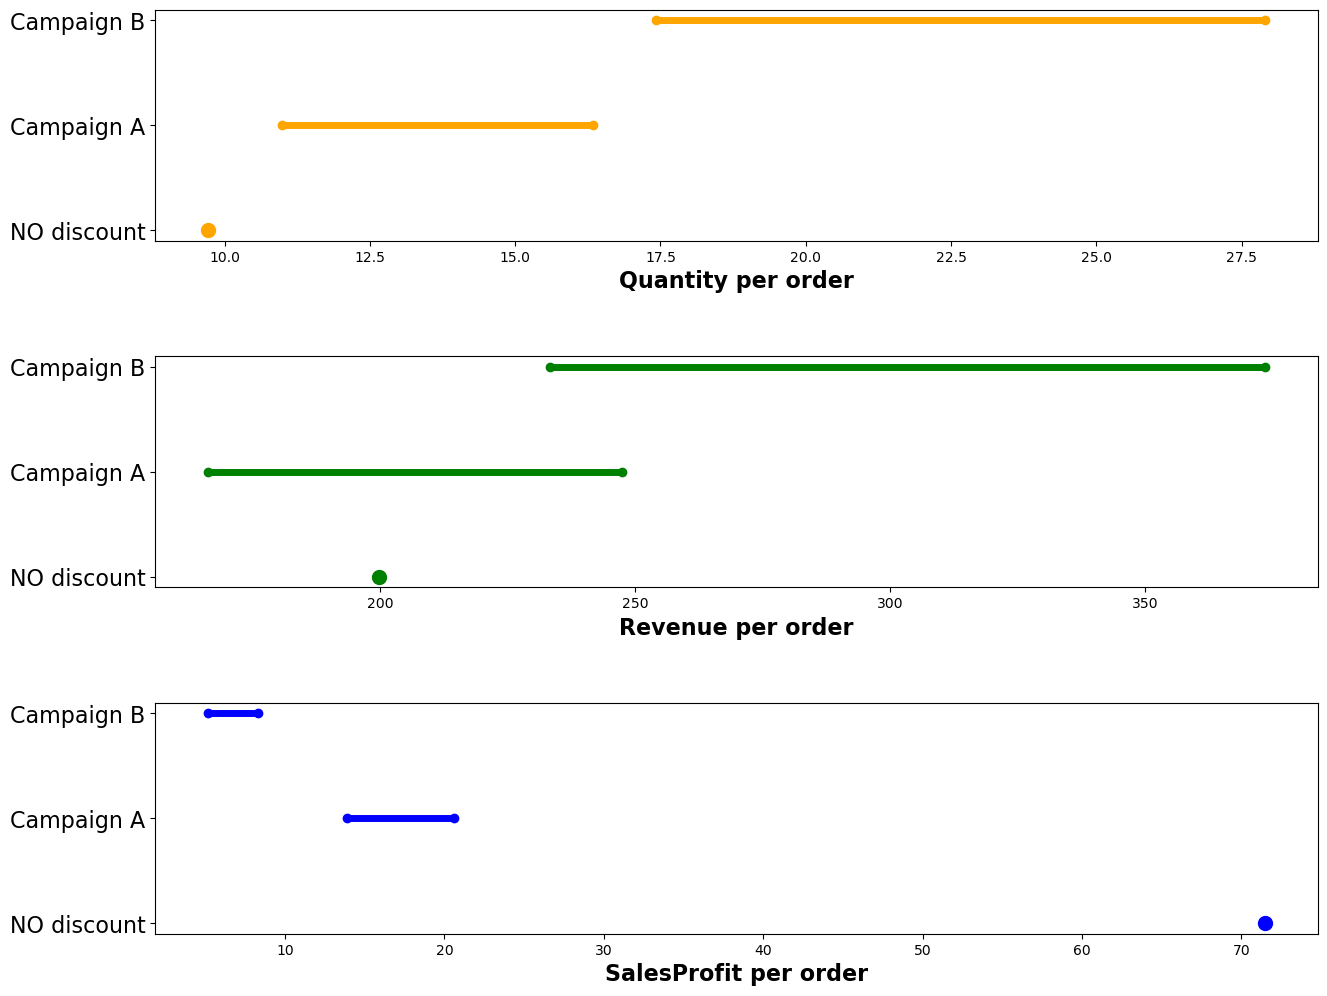

In [61]:
# Plots med konfidensinterval på Quantity, Revenue och Salesprofit per salesorder med discount och utan
fig, ax = plt.subplots(3, 1 , figsize=(15,12))
fig.subplots_adjust(hspace=0.5)

for idx, row in ki_qty.iterrows():
    ax[0].plot([row['Lower_bound'], row['Upper_bound']], [idx, idx], 'o-', color='orange', linewidth=5)
for idx, row in ki_rev.iterrows():
    ax[1].plot([row['Lower_bound'], row['Upper_bound']], [idx, idx], 'o-', color='green', linewidth=5)
for idx, row in ki_prof.iterrows():
    ax[2].plot([row['Lower_bound'], row['Upper_bound']], [idx, idx], 'o-', color='blue', linewidth=5)

ax[0].set_yticks(range(len(ki_qty)))
ax[0].set_yticklabels(list(ki_qty['Measure']), fontsize=16)
ax[0].set_xlabel('Quantity per order', fontweight='bold', fontsize=16)
ax[0].plot(9.72, 0, 'o', color='orange', markersize=10)

ax[1].set_yticks(range(len(ki_rev)))
ax[1].set_yticklabels(list(ki_rev['Measure']), fontsize=16)
ax[1].set_xlabel('Revenue per order', fontweight='bold', fontsize=16)
ax[1].plot(199.73, 0, 'go', markersize=10)

ax[2].set_yticks(range(len(ki_prof)))
ax[2].set_yticklabels(list(ki_prof['Measure']), fontsize=16)
ax[2].set_xlabel('SalesProfit per order', fontweight='bold', fontsize=16)
ax[2].plot(71.49, 0, 'bo', markersize=10)
